# Classification & non-i.i.d. data

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Oulu-IMEDS/stambo/main?labpath=notebooks%2FClassification_non_iid.ipynb)

V1.0.0: © Aleksei Tiulpin, PhD, 2025

This notebook shows an end-to-end example on how one can compare two models on a test set where data has block-diagonal covariance (i.e. non-i.i.d. samples measured e.g. from the same patient)

## Imports

In [1]:
import stambo
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold

SEED = 2025

stambo.__version__

'0.1.4'

## Generating synthetic data with block-diagonal covaraince

We use stambo's synthetic dataset generation functionality to generate the dataset in question.

In [2]:
# Example usage
M = 10  # Number of subjects
N = 400  # Total measurements
dim = 2  # Dimensionality of each measurement

mean_range = np.array((-5, 0))  # Each subject's mean is sampled from this range
base_cov = np.ones((dim, dim))  # Example structured covariance

res = 0
np.random.seed(SEED)
n_measurements_per_subj = stambo.synthetic.generate_n_measurements(M, N, random=True, d_temp=2)
data, subject_ids, _ = stambo.synthetic.generate_non_iid_measurements(n_measurements_per_subj, mean_range, base_cov)

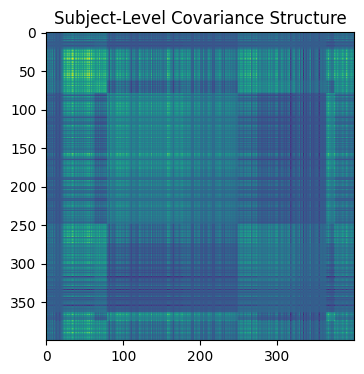

In [3]:
# Besides regenerating the data, we can also bootstrap the covariance matrix

plt.figure(figsize=(4, 4))
plt.imshow(data @ data.T)
plt.title("Subject-Level Covariance Structure")
plt.show()

In [4]:
# Now we can generate the data for a classification task

# Shuffling the data
ind = np.random.choice(data.shape[0], size=data.shape[0], replace=False)
data = data[ind]
subject_ids = subject_ids[ind]

y = np.zeros(N)
y[:int(N*0.3)] = 1
data[:int(N*0.3)] += np.random.randn(int(N*0.3), dim)+2

ind = np.random.choice(data.shape[0], size=data.shape[0], replace=False)
data = data[ind]
subject_ids = subject_ids[ind]
y = y[ind]


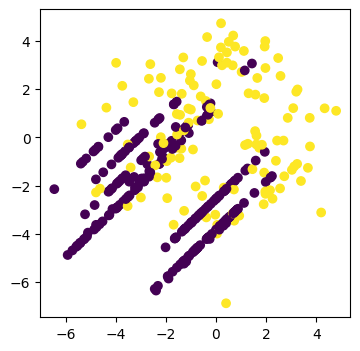

In [5]:
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], c=y)
plt.show()



In [6]:
gss = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=SEED)
train_idx, test_idx = next(gss.split(data, y, groups=subject_ids))

# Split the data into training and testing sets
X_train, X_test = data[train_idx], data[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = subject_ids[train_idx], subject_ids[test_idx]

# Initialize classifiers
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression()

# Train classifiers
knn.fit(X_train, y_train)
logreg.fit(X_train, y_train)

# Make predictions
knn_predictions = knn.predict(X_test)
logreg_predictions = logreg.predict(X_test)

In [7]:
testing_result = stambo.compare_models(y_test, knn_predictions, logreg_predictions, ("ROCAUC", "AP"),seed=SEED, n_bootstrap=1000)
print(stambo.to_latex(testing_result, m1_name="kNN", m2_name="LR"))

Bootstrapping: 100%|██████████| 1000/1000 [00:01<00:00, 772.73it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{lll} \\ 
\toprule 
\textbf{Model} & \textbf{ROCAUC} & \textbf{AP} \\ 
\midrule 
kNN & $0.74$ [$0.63$-$0.85$] & $0.58$ [$0.40$-$0.75$] \\ 
LR & $0.70$ [$0.57$-$0.81$] & $0.52$ [$0.35$-$0.68$] \\ 
\midrule
Effect size & $-0.04$ [$-0.15$-$0.07]$ & $-0.07$ [$-0.20$-$0.06]$ \\ 
\midrule
$p$-value & $0.42$ & $0.25$ \\ 
\bottomrule
\end{tabular}


In [8]:
testing_result = stambo.compare_models(y_test, knn_predictions, logreg_predictions, metrics=("ROCAUC", "AP"), groups=groups_test, seed=SEED, n_bootstrap=1000)
print(stambo.to_latex(testing_result, m1_name="kNN", m2_name="LR"))

Bootstrapping: 100%|██████████| 1000/1000 [00:01<00:00, 565.67it/s]

% \usepackage{booktabs} <-- do not forget to have this imported. 
\begin{tabular}{lll} \\ 
\toprule 
\textbf{Model} & \textbf{ROCAUC} & \textbf{AP} \\ 
\midrule 
kNN & $0.74$ [$0.72$-$0.77$] & $0.58$ [$0.58$-$0.59$] \\ 
LR & $0.70$ [$0.68$-$0.72$] & $0.52$ [$0.51$-$0.53$] \\ 
\midrule
Effect size & $-0.04$ [$-0.04$-$-0.04]$ & $-0.07$ [$-0.08$-$-0.06]$ \\ 
\midrule
$p$-value & $0.00$ & $0.00$ \\ 
\bottomrule
\end{tabular}


According to conventional bootstrap, we did not find any significant difference between the two models. Once we take into account the subject-level structure, we see that the difference is significant, which is valuable in applications.